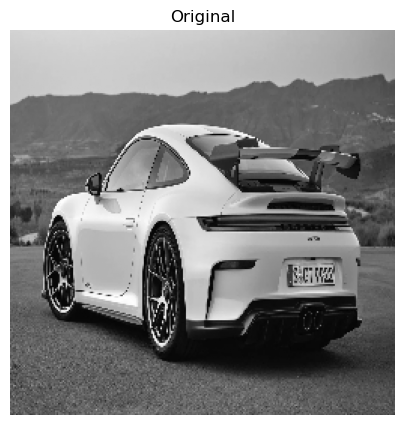

In [1]:
# %%
#  Restore a degraded image using DIRECT INVERSE FILTERING

import cv2
import numpy as np
import matplotlib.pyplot as plt

# ---- Load image (grayscale) ----
img_path = "../image.jpg"   
orig = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
if orig is None:
    raise FileNotFoundError(img_path)

# work with power-of-two-ish size (optional but fast for FFTs)
H, W = 256, 256
orig = cv2.resize(orig, (W, H)).astype(np.float32)

plt.figure(figsize=(5,5))
plt.imshow(orig, cmap="gray")
plt.title("Original")
plt.axis("off"); plt.show()


In [2]:
# %%
# Helpers: centered FFT / IFFT and visualization

def fft2c(im):
    F  = np.fft.fft2(im)
    Fc = np.fft.fftshift(F)
    return Fc

def ifft2c(Fc):
    F  = np.fft.ifftshift(Fc)
    im = np.fft.ifft2(F).real
    return im

def show(im, title="", cmap="gray", s=5):
    plt.figure(figsize=(s,s))
    plt.imshow(im, cmap=cmap)
    plt.title(title); plt.axis("off"); plt.show()

def spectrum(im_or_spec):
    # im_or_spec can be spatial image or already complex spectrum
    if np.iscomplexobj(im_or_spec):
        Fc = im_or_spec
    else:
        Fc = fft2c(im_or_spec)
    return np.log1p(np.abs(Fc))


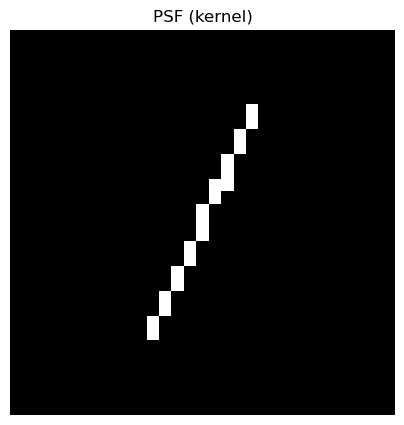

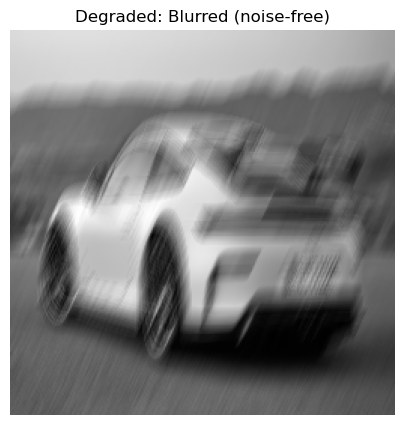

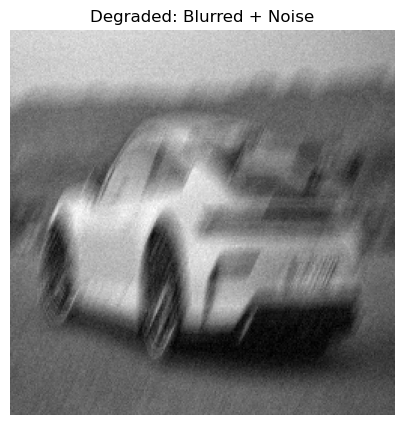

In [3]:
# %%
# Build a blur PSF (Point Spread Function) and degrade the image.
# Two PSFs provided: motion blur or Gaussian blur. Use either.

def psf_motion(size, length=15, angle=20):
    """Linear motion blur PSF of given length and angle (degrees)."""
    PSF = np.zeros((size, size), np.float32)
    center = size // 2
    # draw a line through the center
    cv2.ellipse(PSF, (center, center), (0, length//2), angle, 0, 360, 1, -1)
    PSF /= PSF.sum() + 1e-8
    return PSF

def psf_gaussian(size, sigma=2.0):
    k = cv2.getGaussianKernel(size, sigma)
    PSF = k @ k.T
    PSF /= PSF.sum()
    return PSF

# ---- choose a PSF (uncomment one) ----
psf_size = 31
PSF = psf_motion(psf_size, length=21, angle=25)
# PSF = psf_gaussian(psf_size, sigma=3.0)

# pad PSF to image size and center it for FFT-based convolution
pad = np.zeros_like(orig)
ps = PSF.shape[0]
pad[:ps, :ps] = PSF
# circularly shift to center the impulse response at (0,0) for proper FFT convolution
pad = np.roll(np.roll(pad, -ps//2, axis=0), -ps//2, axis=1)

Hk = fft2c(pad)  # OTF (optical transfer function) = FFT of PSF

# Degrade: blur in spatial (for intuition) and optionally add noise
blurred = cv2.filter2D(orig, -1, PSF, borderType=cv2.BORDER_REFLECT)

# add Gaussian noise (set sigma=0 for noise-free case)
def add_gauss(u8_like_f32, sigma=4.0, seed=0):
    rng = np.random.default_rng(seed)
    n = rng.normal(0, sigma, u8_like_f32.shape).astype(np.float32)
    return np.clip(u8_like_f32 + n, 0, 255)

noisy_blurred = add_gauss(blurred, sigma=6.0)

show(PSF, "PSF (kernel)")
show(blurred, "Degraded: Blurred (noise-free)")
show(noisy_blurred, "Degraded: Blurred + Noise")


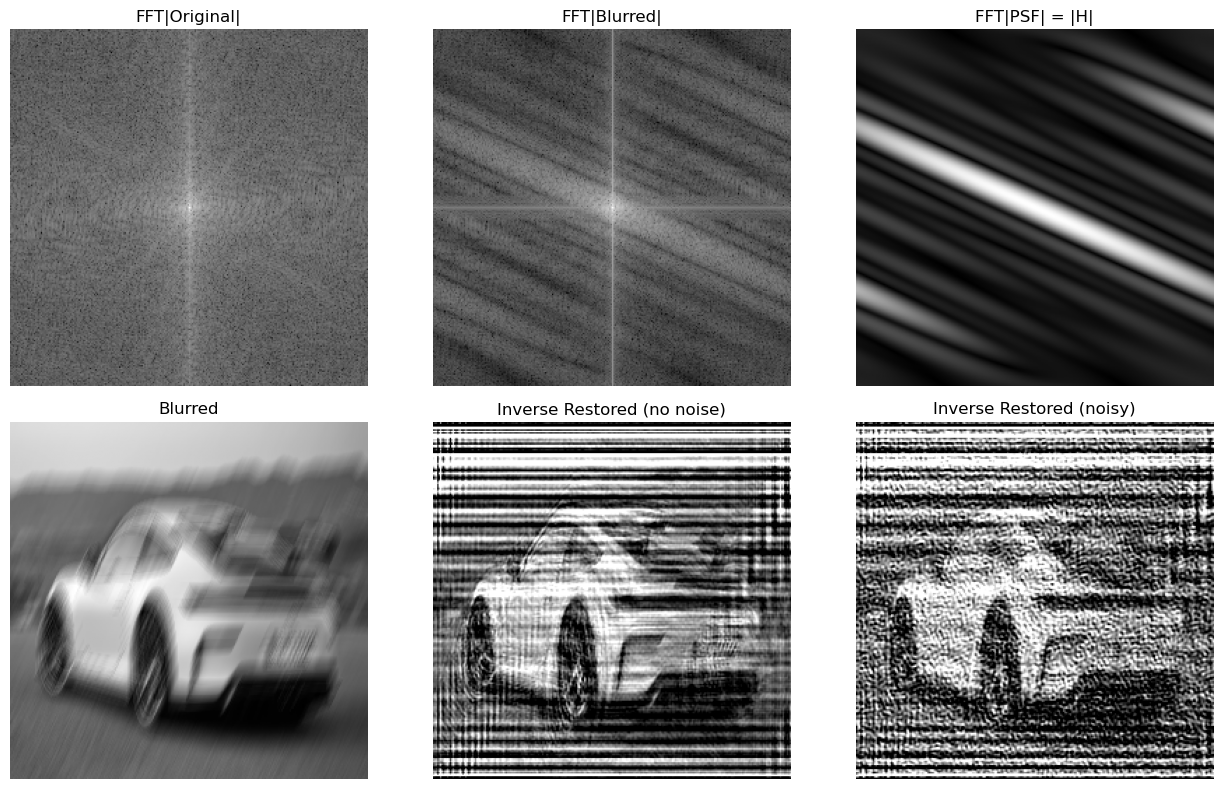

In [4]:
# %%
# DIRECT INVERSE FILTERING
#    F_hat = G / H   with a small threshold to avoid division by near-zeros in H.
# Optional: radius mask to suppress extreme high-freq amplification.

def inverse_filter(degraded, Hk, eps=1e-3, use_radius_mask=True, radius=100):
    """
    degraded: degraded image (float32, 0..255)
    Hk: complex OTF (FFT of centered PSF, same size as image)
    eps: floor for |H| to guard division by ~0
    use_radius_mask: limit restoration to a radius in frequency to stabilize
    """
    Gc = fft2c(degraded)
    H_mag = np.abs(Hk)
    H_safe = Hk.copy()
    H_safe[H_mag < eps] = eps * np.exp(1j * np.angle(Hk[H_mag < eps]))  # keep phase

    F_est = Gc / H_safe

    if use_radius_mask:
        # build circular mask (keep low/mid frequencies)
        rows, cols = degraded.shape
        u = np.arange(rows) - rows//2
        v = np.arange(cols) - cols//2
        V, U = np.meshgrid(v, u)
        R = np.sqrt(U**2 + V**2)
        M = (R <= radius).astype(np.float32)
        F_est *= M

    rec = ifft2c(F_est)
    return np.clip(rec, 0, 255).astype(np.float32)

# Try on noise-free and noisy versions
restored_nf = inverse_filter(blurred, Hk, eps=1e-3, use_radius_mask=True, radius=110)
restored_n  = inverse_filter(noisy_blurred, Hk, eps=3e-2, use_radius_mask=True, radius=90)

# Show spectra and results
fig, ax = plt.subplots(2,3, figsize=(13,8))
ax[0,0].imshow(spectrum(orig), cmap="gray");          ax[0,0].set_title("FFT|Original|"); ax[0,0].axis("off")
ax[0,1].imshow(spectrum(blurred), cmap="gray");       ax[0,1].set_title("FFT|Blurred|");  ax[0,1].axis("off")
ax[0,2].imshow(np.log1p(np.abs(Hk)), cmap="gray");    ax[0,2].set_title("FFT|PSF| = |H|"); ax[0,2].axis("off")
ax[1,0].imshow(blurred, cmap="gray");                 ax[1,0].set_title("Blurred");       ax[1,0].axis("off")
ax[1,1].imshow(restored_nf, cmap="gray");             ax[1,1].set_title("Inverse Restored (no noise)"); ax[1,1].axis("off")
ax[1,2].imshow(restored_n, cmap="gray");              ax[1,2].set_title("Inverse Restored (noisy)");    ax[1,2].axis("off")
plt.tight_layout(); plt.show()


In [5]:
# %%
# (Optional) Quantitative: PSNR to compare recovery quality

def psnr(ref, test):
    ref = ref.astype(np.float32); test = test.astype(np.float32)
    mse = np.mean((ref - test)**2)
    return 99. if mse < 1e-12 else 10*np.log10((255**2)/mse)

print(f"PSNR blurred (noisefree) vs orig : {psnr(orig, blurred):.2f} dB")
print(f"PSNR restored (noisefree) vs orig: {psnr(orig, restored_nf):.2f} dB")
print(f"PSNR blurred+noise vs orig       : {psnr(orig, noisy_blurred):.2f} dB")
print(f"PSNR restored (noisy) vs orig    : {psnr(orig, restored_n):.2f} dB")


PSNR blurred (noisefree) vs orig : 18.47 dB
PSNR restored (noisefree) vs orig: 10.62 dB
PSNR blurred+noise vs orig       : 18.31 dB
PSNR restored (noisy) vs orig    : 10.08 dB
